In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

# Beam Class Regression Tests
----

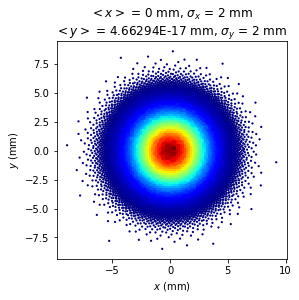

In [29]:
from distgen import Generator
from distgen.plot import plot_dist2d

input_file = "../examples/data/rad.gaussian.in.json"
gen = Generator(input_file,verbose=0)
gen.input['n_particle']=100000
beam = gen.beam()

plot_dist2d(beam, 'x', 'mm', 'y', 'mm', title_on=True, axis='equal')

# Beam weights must be normalized:

$\sum_i w_i = 1$

In [21]:
from distgen.beam import Beam2
b = Beam2(total_charge=beam.q, n_particle=len(beam['x']) )

var ={'x', 'y', 'z', 'px', 'py', 'pz', 't'}

b['x']=beam['x']
b['y']=beam['y']
b['z']=beam['z']

b['px']=beam['px']
b['py']=beam['py']
b['pz']=beam['pz']

b['w']=beam['w']
b['t']=beam['t']


ImportError: cannot import name 'Beam2'

[1.550544060412256 -1.8458857862050664 -0.5168480201374186 0.8121897459302295 -1.4028731975158504 -0.07383543144820265 1.255202334619445 -0.9598606088266346 0.3691771572410133 1.6982149233086612 -1.6982149233086612 -0.3691771572410133 0.9598606088266346 -1.2552023346194452 0.07383543144820268 1.4028731975158504 -0.8121897459302293 0.5168480201374188 1.8458857862050666 -1.9443330281360034 -0.6152952620683555 0.7137425039992922 -1.5013204394467874 -0.17228267337913955 1.1567550926885084 -1.0583078507575714 0.2707299153100769 1.5997676813777246 -1.796662165239598 -0.4676243991719502 0.8614133668956981 -1.353649576550382 -0.024611810482734208 1.3044259555849136 -0.9106369878611662 0.41840077820648197 1.7474385442741298 -1.6489913023431928 -0.31995353627554485 1.0090842297921034 -1.2059787136539768 0.12305905241367089 1.4520968184813188 -0.7629661249647609 0.5660716411028871 1.895109407170535 -1.895109407170535 -0.5660716411028871 0.7629661249647609 -1.452096818481319 -0.12305905241367109 1

In [6]:
print(x)

NameError: name 'x' is not defined